In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import mlflow
import wandb
import seaborn as sns
from IPython.display import display, clear_output
import PIL.Image
import time
%matplotlib inline

from nets.DDPGAgent import DDPGAgent

In [2]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

# Initialize Weights & Biases
wandb.init(project="DDPG-Pendulum", config={
    "episodes": 1000,
    "batch_size": 128,
    "buffer_size": int(1e5),
    "gamma": 0.99,
    "tau": 1e-3,
    "actor_lr": 1e-4,
    "critic_lr": 1e-3,
    "weight_decay": 0,
    "state_size": 3,    # Assuming state size and action size are constants, you can also make them configurable
    "action_size": 1,
    "random_seed": 42
})

# Start an MLflow run
mlflow.start_run()
mlflow.log_params(wandb.config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amoz (arashmozhdehi). Use `wandb login --relogin` to force relogin


In [3]:
agent = DDPGAgent(
    state_size=state_size,
    action_size=action_size,
    random_seed=wandb.config.random_seed,
    batch_size=wandb.config.batch_size,
    buffer_size=wandb.config.buffer_size,
    gamma=wandb.config.gamma,
    tau=wandb.config.tau,
    actor_lr=wandb.config.actor_lr,
    critic_lr=wandb.config.critic_lr,
    weight_decay=wandb.config.weight_decay
)

In [ ]:
def add_info_to_frame(img, title, score):
    from PIL import ImageDraw, ImageFont
    
    # Convert to RGB if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Initialize drawing context
    draw = ImageDraw.Draw(img)
    
    # Add text to image
    text = f"{title}\nScore: {score:.2f}"
    draw.text((10, 10), text, fill="white")
    
    return img

In [ ]:
def display_frames_with_info(frames, title, score):
    for frame in frames:
        img = PIL.Image.fromarray(frame)
        img_with_info = add_info_to_frame(img, title, score)
        display(img_with_info)
        clear_output(wait=True)

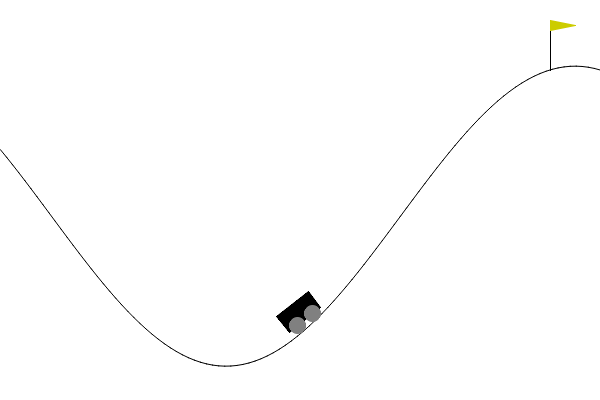

Episode: 18
Score: -12.75


KeyboardInterrupt: 

In [8]:
def ddpg(n_episodes=3000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []

    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        agent.reset()
        score = 0
        frames = []
        for t in range(max_t):
            if isinstance(state, tuple):
                state = np.array(state[0])
            state = np.array(state, dtype=np.float32)
            action = agent.act(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            agent.step(state, action, reward, next_state, terminated or truncated)
            state = next_state
            score += reward
            
            # Capture the frame
            frame = env.render()
            frames.append(frame)
            
            if terminated or truncated:
                break

        scores_deque.append(score)
        scores.append(score)
        wandb.log({"Average Score": np.mean(scores_deque)})
        mlflow.log_metric("Score", score, step=i_episode)

    mlflow.end_run()
    return scores



# Use the refactored function
scores = ddpg()